In [ ]:
import cv2
import splitfolders
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Split dataset
dataset_folder = "Mesidoir_Dataset"
splitfolders.ratio(dataset_folder, output="DR_Splitted", seed=42, ratio=(.70, .20, .10), group_prefix=None)

In [ ]:
def preprocess_image(image):
    
    # Resize to 200x200
    resized = cv2.resize(image, (200, 200))
    
    # Normalize to [0, 1] range
    normalized = resized.astype(np.float32) / 255.0
    
    return normalized

In [6]:
# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

In [7]:
# Parameters
batch_size = 32
img_size = 200
epochs = 100
target_size = (img_size, img_size)

train_path = "DR_Splitted/train"
val_path = "DR_Splitted/val"
test_path = "DR_Splitted/test"

# Create generators
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

val_generator = test_val_datagen.flow_from_directory(
    directory=val_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

test_generator = test_val_datagen.flow_from_directory(
    directory=test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

Found 838 images belonging to 4 classes.
Found 238 images belonging to 4 classes.
Found 124 images belonging to 4 classes.


In [8]:
# Get class names and number of classes
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")

Classes: ['0', '1', '2', '3']
Number of classes: 4


In [9]:
def se_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation block"""
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    return layers.Multiply()([input_tensor, layers.Reshape((1, 1, filters))(se)])

In [10]:
def build_model(num_classes):
    """Build CNN model with SE blocks"""
    inputs = layers.Input((img_size, img_size, 3))

    # Block 1
    x = layers.Conv2D(32, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    xM = layers.MaxPooling2D(pool_size=2)(x)
    xA = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.concatenate([xM, xA], axis=-1)

    # Block 2
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    xM2 = layers.MaxPooling2D(pool_size=2)(x)
    xA2 = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.concatenate([xM2, xA2], axis=-1)

    # SE block
    x = se_block(x)

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, x)

# Build and compile model
model = build_model(num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 200, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
model.compile(
    optimizer=optimizers.SGD(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]


In [12]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
27/27 [==============================] - 36s 1s/step - loss: 1.3428 - accuracy: 0.3747 - val_loss: 1.3732 - val_accuracy: 0.4580 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 34s 1s/step - loss: 1.3173 - accuracy: 0.4356 - val_loss: 1.3580 - val_accuracy: 0.4580 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 33s 1s/step - loss: 1.3151 - accuracy: 0.4296 - val_loss: 1.3430 - val_accuracy: 0.4580 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 33s 1s/step - loss: 1.3089 - accuracy: 0.4403 - val_loss: 1.3296 - val_accuracy: 0.4580 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 32s 1s/step - loss: 1.2904 - accuracy: 0.4475 - val_loss: 1.3176 - val_accuracy: 0.4580 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 33s 1s/step - loss: 1.2896 - accuracy: 0.4511 - val_loss: 1.3068 - val_accuracy: 0.4580 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 35s 1s/step - loss: 1.2

In [13]:
print("\n" + "="*80)
print("EVALUATION STARTED")
print("="*80)

# Load best model
model = keras.models.load_model("best_model.keras")


EVALUATION STARTED


In [14]:
# Test set evaluation
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"\nTest Set:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")


Test Set:
  Loss: 1.2299
  Accuracy: 0.4516


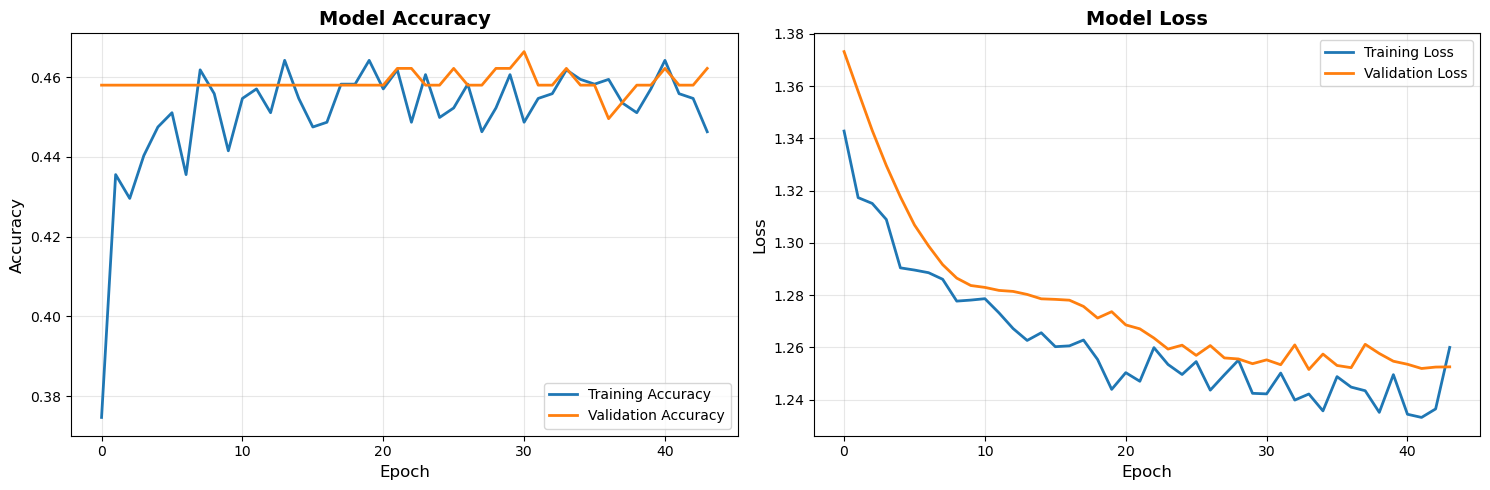

✓ Training history plots saved as 'training_history.png'


In [ ]:
# PLOT TRAINING HISTORY (Accuracy and Loss Curves)
def plot_training_history(history):
    """Plot training and validation accuracy/loss curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Training history plots saved as 'training_history.png'")

plot_training_history(history)

In [16]:
# 2. GENERATE PREDICTIONS FOR TEST SET
def get_predictions(generator, model):
    """Get predictions and true labels from generator"""
    generator.reset()
    steps = len(generator)
    
    y_pred = []
    y_true = []
    
    for i in range(steps):
        x_batch, y_batch = generator[i]
        predictions = model.predict(x_batch, verbose=0)
        y_pred.extend(predictions)
        y_true.extend(y_batch)
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    return y_pred, y_true

print("\nGenerating predictions on test set...")
y_pred, y_true = get_predictions(test_generator, model)



Generating predictions on test set...


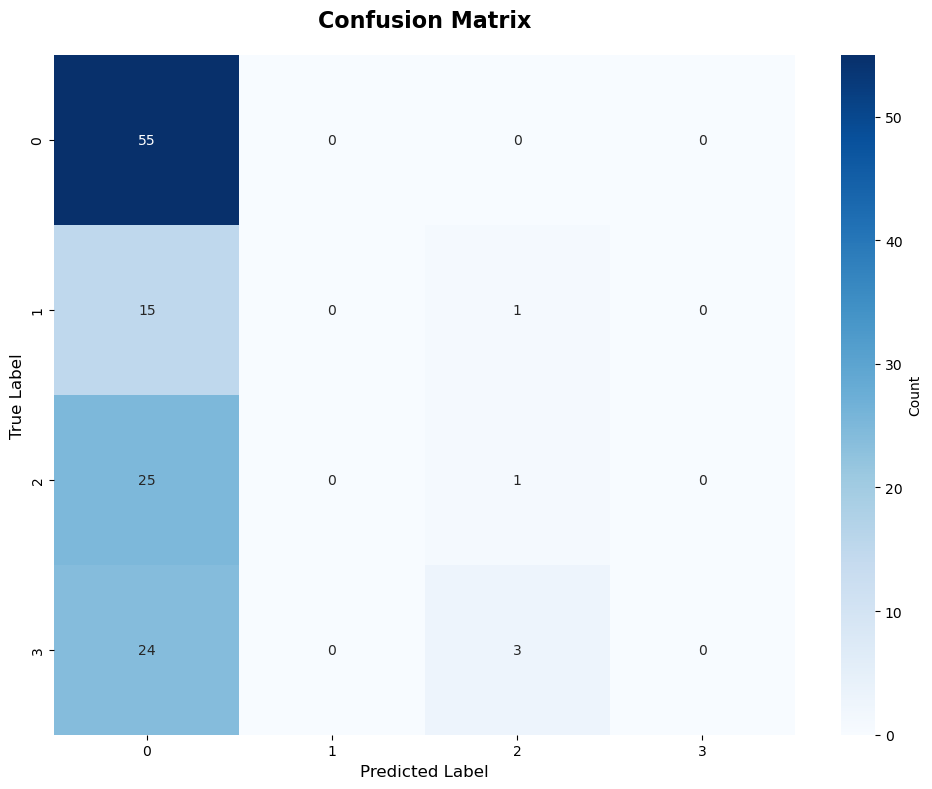

✓ Confusion matrix saved as 'confusion_matrix.png'

Classification Report:
              precision    recall  f1-score   support

           0     0.4622    1.0000    0.6322        55
           1     0.0000    0.0000    0.0000        16
           2     0.2000    0.0385    0.0645        26
           3     0.0000    0.0000    0.0000        27

    accuracy                         0.4516       124
   macro avg     0.1655    0.2596    0.1742       124
weighted avg     0.2469    0.4516    0.2939       124



C:\Users\saifu\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saifu\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saifu\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [17]:
# Convert to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# 3. CONFUSION MATRIX
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Confusion matrix saved as 'confusion_matrix.png'")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

plot_confusion_matrix(y_true_classes, y_pred_classes, class_names)

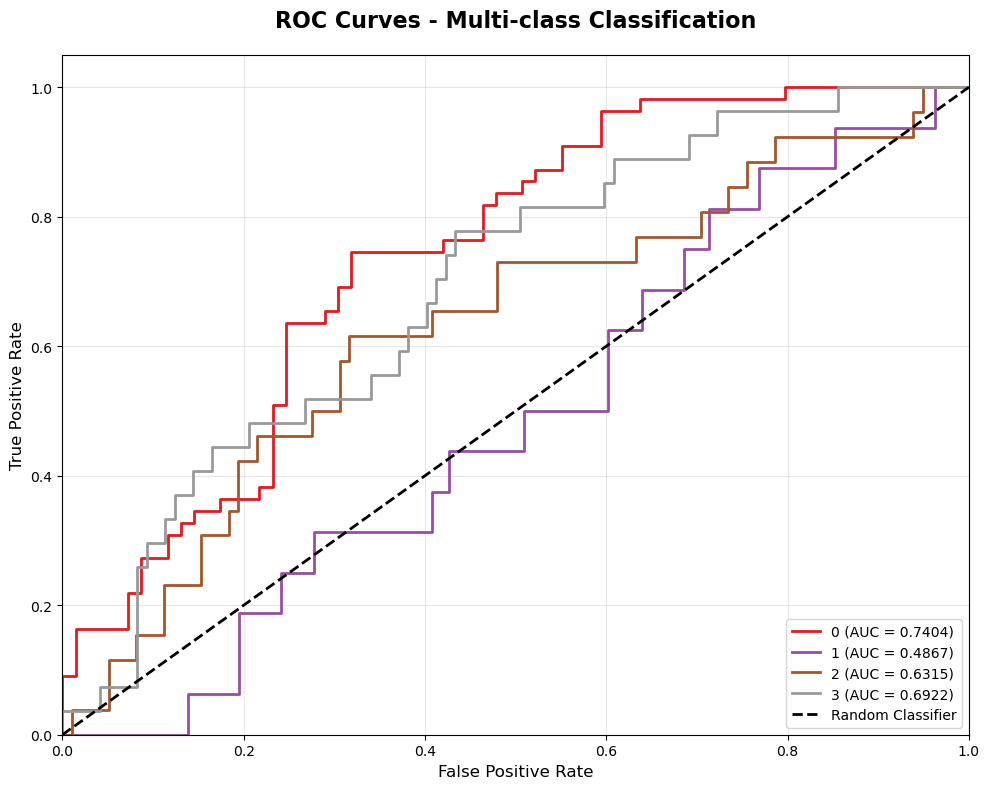

✓ ROC-AUC curves saved as 'roc_auc_curves.png'

AUC Scores per class:
  0: 0.7404
  1: 0.4867
  2: 0.6315
  3: 0.6922

Macro-average AUC: 0.6377


In [ ]:
# ROC CURVE AND AUC (for multi-class)
def plot_roc_auc_multiclass(y_true, y_pred, class_names):
    """Plot ROC curves and calculate AUC for multi-class classification"""
    n_classes = len(class_names)
    
    plt.figure(figsize=(10, 8))
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    colors = plt.cm.Set1(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Multi-class Classification', fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_auc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ ROC-AUC curves saved as 'roc_auc_curves.png'")
    
    # Print AUC scores
    print("\nAUC Scores per class:")
    for i in range(n_classes):
        print(f"  {class_names[i]}: {roc_auc[i]:.4f}")
    
    # Compute macro-average AUC
    macro_auc = np.mean(list(roc_auc.values()))
    print(f"\nMacro-average AUC: {macro_auc:.4f}")

plot_roc_auc_multiclass(y_true, y_pred, class_names)
